In [1]:
## multi-input time series
## include high, low, open, close, volumn

#Parameters:
NUM_OF_YEARS = 20
STOCKS = ['GOOG', 'TSLA', 'XOM', 'UNH', 'JNJ', 'JPM', 'V', 'PG', 'HD', 'CVX', 'MA', 'LLY', 'MRK', 'MSFT' ]
#STOCKS = ['XOM']
NUM_LSTM_DAYS = 60
EPOCHS = 100
BATCH_SIZE = 4096

In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional
import matplotlib.pyplot as plt
from datetime import datetime
import os.path
from pathlib import Path

print(tf.config.list_physical_devices('GPU'))

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
plt.style.use('fivethirtyeight')

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6



In [3]:
def show_close(df):
    plt.figure(figsize=(16,8))
    plt.title('Close Price History')
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD', fontsize=18)
    plt.show()

def get_data(stock):
    end = datetime.today()
    start = datetime(end.year-NUM_OF_YEARS,end.month,end.day)
    data_path = 'data/' + stock +"_" + str(start.year)+str(end.year)+".csv"
    if not os.path.exists('data/'):
        os.makedirs('data/')
    df = pd.DataFrame()
    my_file = Path(data_path)
    if not my_file.is_file():
        print("loading_data")
        df = yf.download(stock, start=start, end=end)
        df.to_csv(data_path)
    df = pd.read_csv(data_path)
    df = df.set_index('Date')
    return df


def init_model(x_train_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(150, return_sequences=True, input_shape= (x_train_shape[1], x_train_shape[2]), dropout=0.1 )))
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [4]:
def train_data(stock, model):
    df = get_data(stock)
    training_data_len = math.ceil(len(df)*0.8)
    df = df[:training_data_len]  

    scaler = StandardScaler()
    volumn_train_data = scaler.fit_transform(df[['Volume']].values)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(df[['High']].values+df[['Low']].values)
    high_train_data = scaler.transform(df[['High']].values)
    low_train_data = scaler.transform(df[['Low']].values)
    open_train_data = scaler.transform(df[['Open']].values)
    close_train_data = scaler.transform(df[['Close']].values)

    x_train = []
    y_train = []

    for i in range(NUM_LSTM_DAYS, len(high_train_data)):
        temp = []
        for j in range(i-NUM_LSTM_DAYS, i):
            temp.append([high_train_data[j,0], low_train_data[j,0], open_train_data[j,0], 
                        close_train_data[j,0], volumn_train_data[j,0] ])
        x_train.append(temp)
        y_train.append(close_train_data[i,0])

    np.array(x_train).shape

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_train.shape

    if(model == None):
        model = init_model(x_train.shape)
    
    with tf.device('/gpu:0'):
        history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
        plt.plot(history.history['loss'])
        plt.title('model train vs validation loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
        
    if not os.path.exists('model/'):
        os.makedirs('model/')
    model.save('model/LSTM_bidirectional.h5') 


-----------Train stock:  GOOG  ----------------------
----------------------------------------------------------


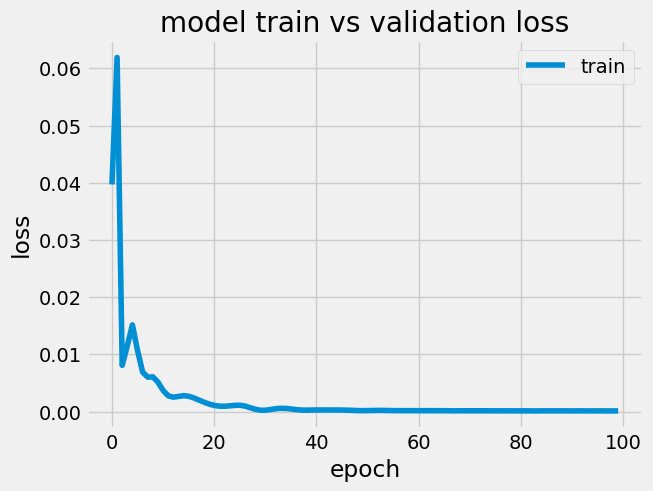

-----------Train stock:  TSLA  ----------------------
----------------------------------------------------------


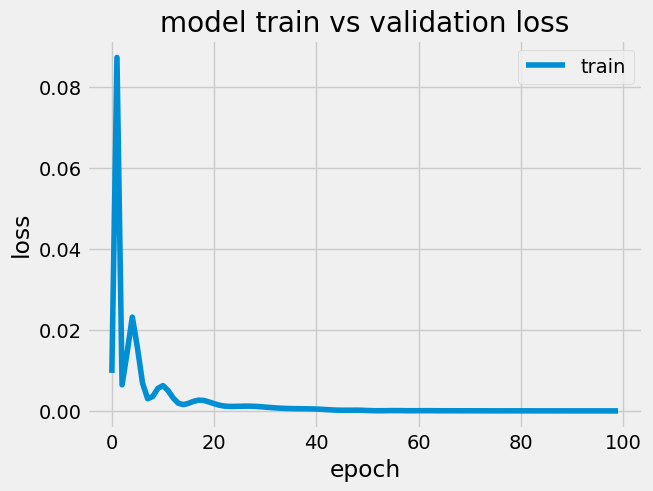

-----------Train stock:  XOM  ----------------------
----------------------------------------------------------


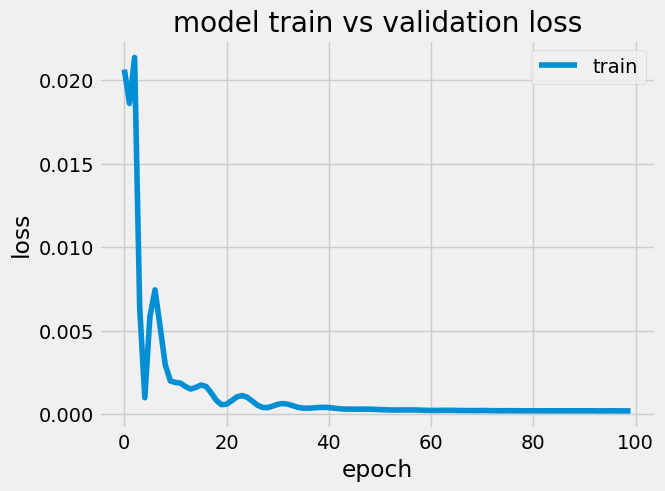

-----------Train stock:  UNH  ----------------------
----------------------------------------------------------


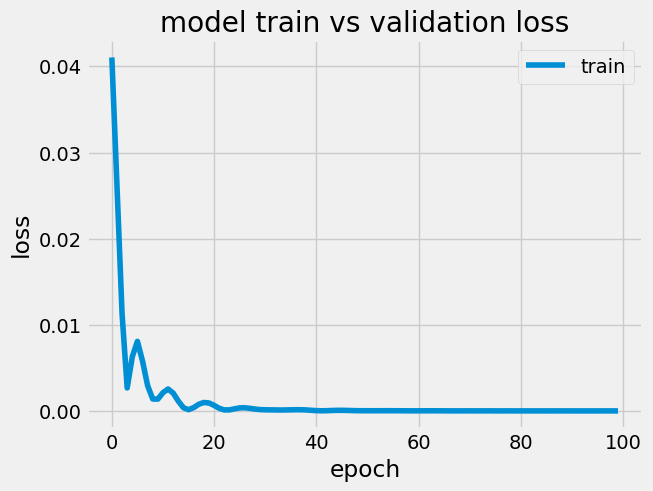

-----------Train stock:  JNJ  ----------------------
----------------------------------------------------------


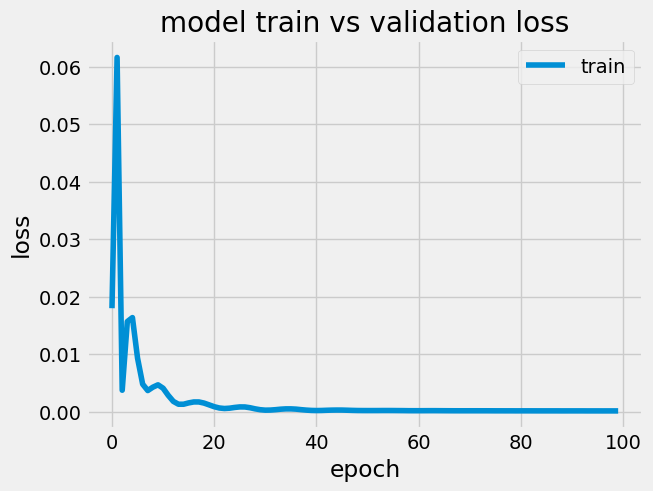

-----------Train stock:  JPM  ----------------------
----------------------------------------------------------


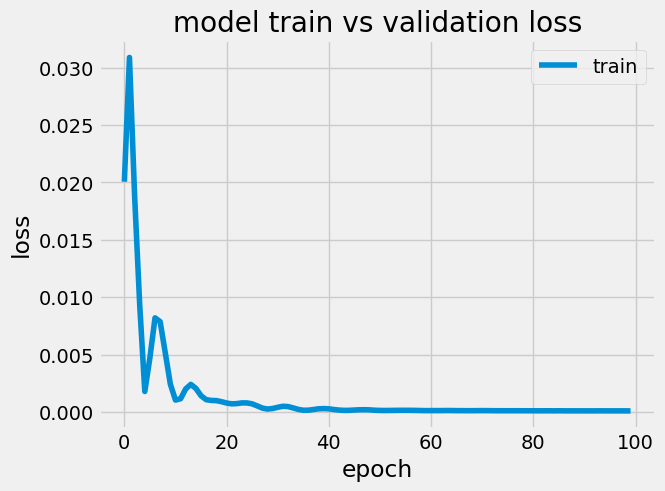

-----------Train stock:  V  ----------------------
----------------------------------------------------------


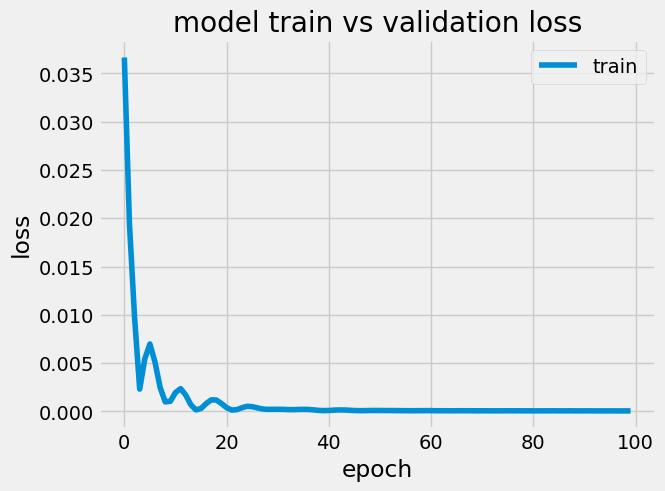

-----------Train stock:  PG  ----------------------
----------------------------------------------------------


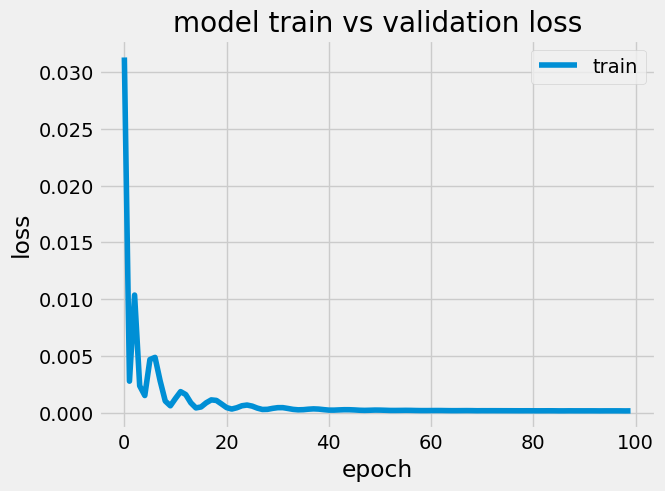

-----------Train stock:  HD  ----------------------
----------------------------------------------------------


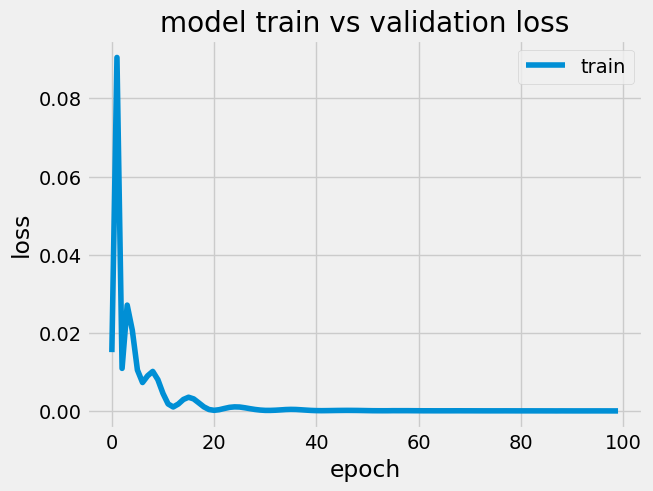

-----------Train stock:  CVX  ----------------------
----------------------------------------------------------


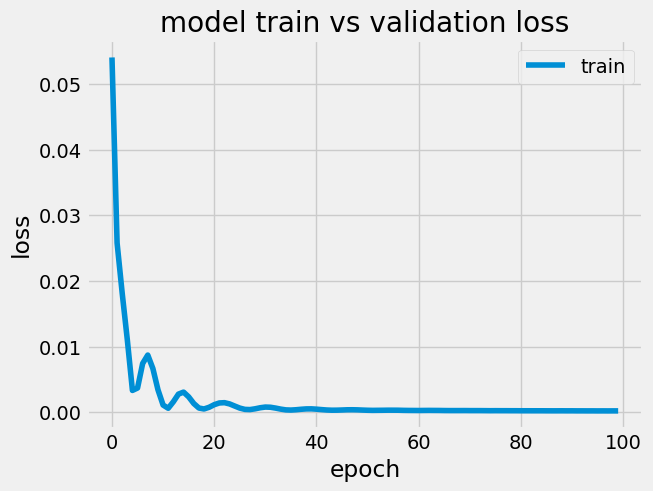

-----------Train stock:  MA  ----------------------
----------------------------------------------------------


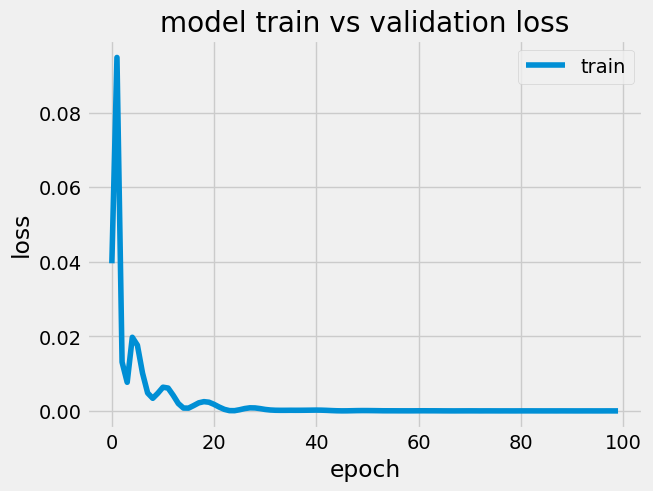

-----------Train stock:  LLY  ----------------------
----------------------------------------------------------


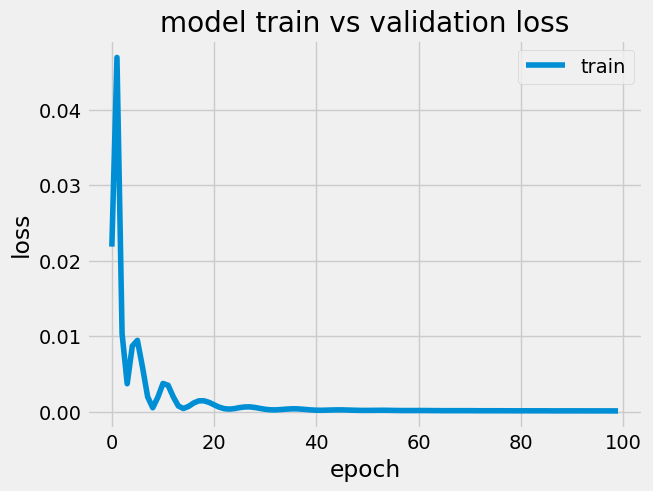

-----------Train stock:  MRK  ----------------------
----------------------------------------------------------


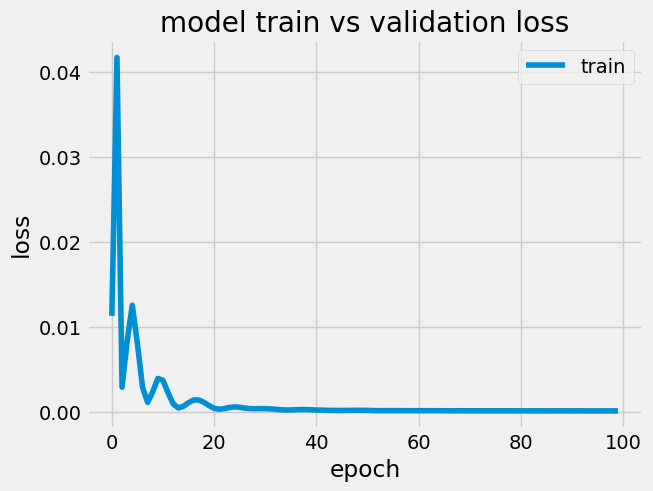

-----------Train stock:  MSFT  ----------------------
----------------------------------------------------------


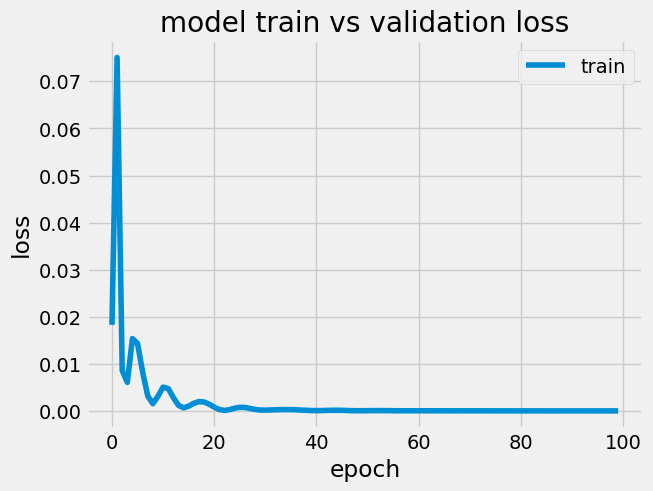

In [5]:
model = None
for stock in STOCKS:
    print("-----------Train stock: ", stock, " ----------------------")
    print("----------------------------------------------------------")
    train_data(stock, model)

In [6]:
def test_data(stock, model):
    df = get_data(stock)

    high_dataset = df[['High']].values
    low_dataset = df[['Low']].values
    open_dataset = df[['Open']].values
    volumn_dataset = df[['Volume']].values
    close_dataset = df[['Close']].values

    training_data_len = math.ceil(len(close_dataset)*0.8)

    scaler = StandardScaler()
    volumn_dataset = scaler.fit_transform(volumn_dataset)

    hight_test_data = high_dataset[training_data_len - NUM_LSTM_DAYS:, :]
    low_test_data = low_dataset[training_data_len - NUM_LSTM_DAYS:, :]
    open_test_data = open_dataset[training_data_len - NUM_LSTM_DAYS:, :]
    volumn_test_data = volumn_dataset[training_data_len - NUM_LSTM_DAYS:, :]
    close_test_data = close_dataset[training_data_len - NUM_LSTM_DAYS:, :]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(hight_test_data+low_test_data)

    hight_test_data = scaler.transform(hight_test_data)
    low_test_data = scaler.transform(low_test_data)
    open_test_data = scaler.transform(open_test_data)
    close_test_data = scaler.transform(close_test_data)
    

    x_test = []
    y_test = close_dataset[training_data_len:, :]

    for i in range(NUM_LSTM_DAYS, len(hight_test_data)):
        temp = []
        for j in range(i-NUM_LSTM_DAYS, i):
            temp.append([hight_test_data[j,0], low_test_data[j,0], open_test_data[j,0], 
                        close_test_data[j,0], volumn_test_data[j,0] ])
        x_test.append(temp)
        
    x_test = np.array(x_test)
    x_test.shape

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    predictions.size
    rmse = np.sqrt(np.mean(predictions-y_test)**2)
    print("rmse: ", rmse)

    valid = df.filter(['Close'])[training_data_len:]
    print("valid: ", valid)

    valid['Predictions'] = predictions
    prev = valid['Close'][0]
    sum = 0
    count = 0 
    is_incorrect_direation = []
    is_incorrect_direation.append(0)
    for idx, p in enumerate(valid['Close'][1:]):
        sum+=abs(p-prev)
        if( (p-prev>0 and valid['Predictions'][idx]-prev<0) or (p-prev<0 and valid['Predictions'][idx]-prev>0)):
            count +=1
            is_incorrect_direation.append(10)
        else:
            is_incorrect_direation.append(-10)
        #origin_volatility.append((p-prev)*1)
        prev=p
        
    print("Avg volatility: ", sum/(valid['Close'].size-1))
    print("Wrong direction count: ", count, "/", (valid['Close'].size-1))
    valid['is_incorrect_direation'] = is_incorrect_direation

    plt.figure(figsize=(32,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD', fontsize=18)
    #plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions','is_incorrect_direation']])
    plt.legend(['Close', 'Predications','is_incorrect_direation'])
    plt.show()

32/32 [==============================] - 2s 13ms/step
rmse:  0.4442093623561366
valid:                                  Close
Date                                 
2019-02-01 00:00:00-05:00   41.630001
2019-02-04 00:00:00-05:00   42.812500
2019-02-05 00:00:00-05:00   43.544998
2019-02-06 00:00:00-05:00   43.560001
2019-02-07 00:00:00-05:00   42.735001
...                               ...
2023-01-24 00:00:00-05:00  142.529999
2023-01-25 00:00:00-05:00  141.860001
2023-01-26 00:00:00-05:00  143.960007
2023-01-27 00:00:00-05:00  145.929993
2023-01-30 00:00:00-05:00  143.000000

[1006 rows x 1 columns]
Avg volatility:  1.727616590053881
Wrong direction count:  513 / 1005


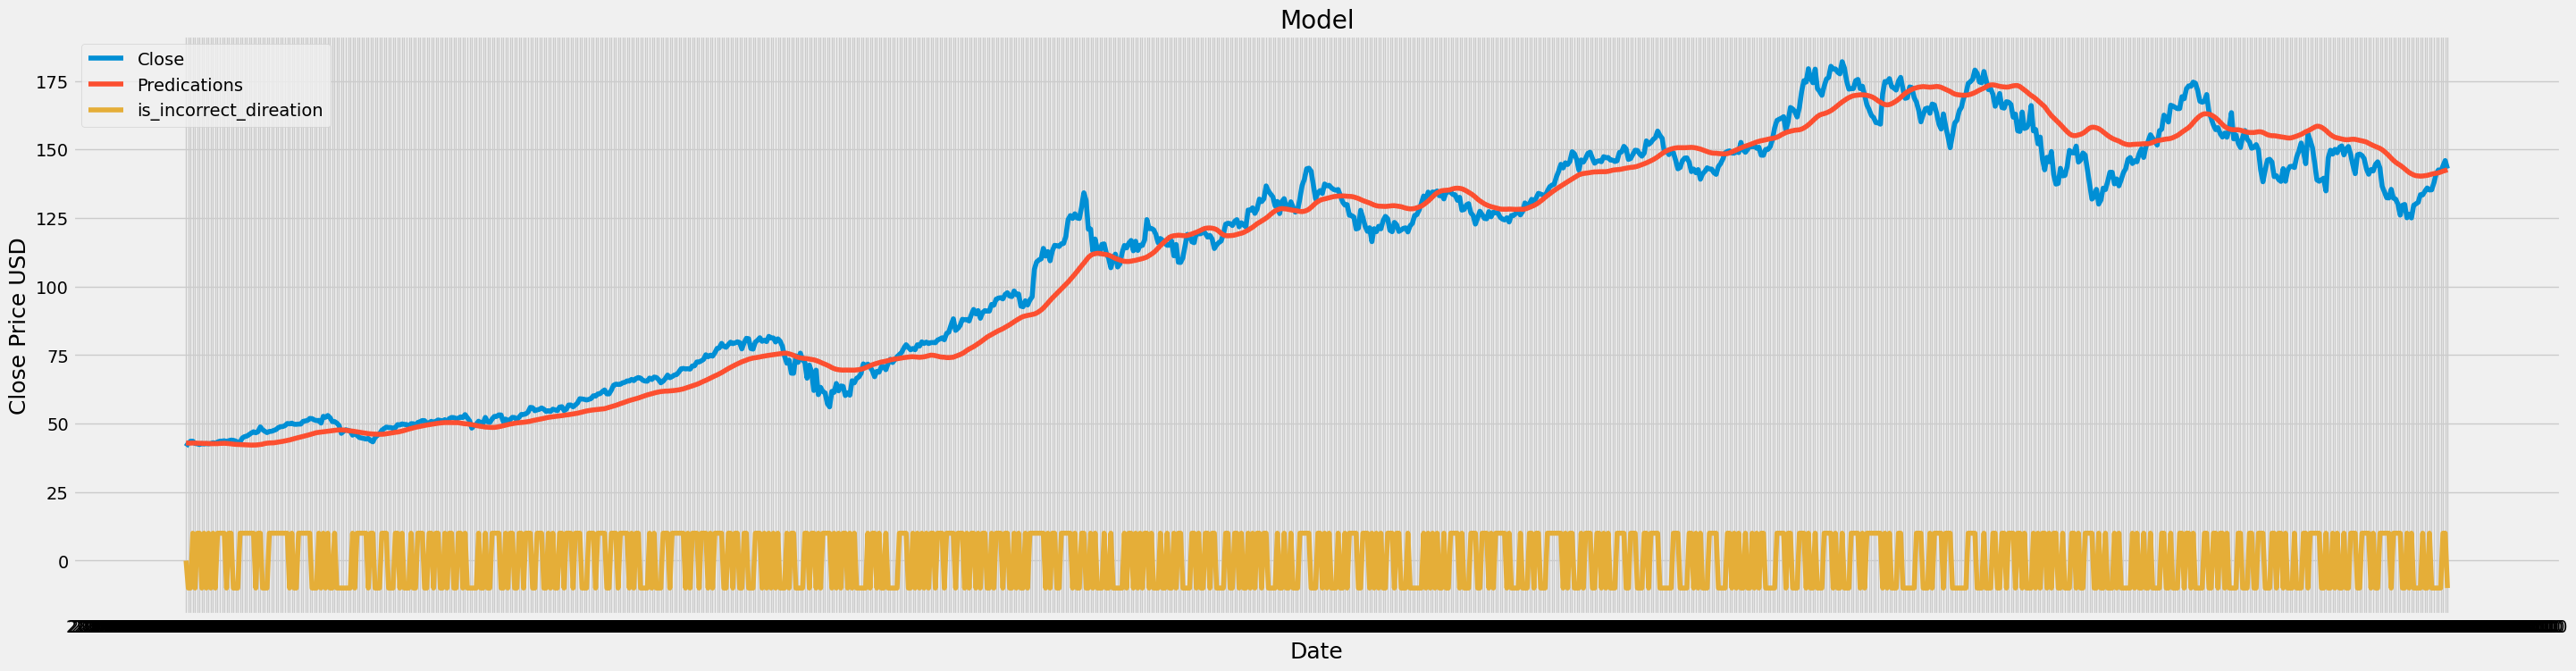

In [7]:
import keras as ks
test_data('AAPL', ks.models.load_model('model/LSTM_bidirectional.h5'))